In [10]:
!pip install umap-learn


  Obtaining dependency information for umap-learn from https://files.pythonhosted.org/packages/6b/b1/c24deeda9baf1fd491aaad941ed89e0fed6c583a117fd7b79e0a33a1e6c0/umap_learn-0.5.9.post2-py3-none-any.whl.metadata
  Obtaining dependency information for scikit-learn>=1.6 from https://files.pythonhosted.org/packages/8d/a1/d3a7628630a711e2ac0d1a482910da174b629f44e7dd8cfcd6924a4ef81a/scikit_learn-1.7.1-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for pynndescent>=0.5 from https://files.pythonhosted.org/packages/d2/53/d23a97e0a2c690d40b165d1062e2c4ccc796be458a1ce59f6ba030434663/pynndescent-0.5.13-py3-none-any.whl.metadata
  Obtaining dependency information for numpy>=1.23 from https://files.pythonhosted.org/packages/c0/bc/77635c657a3668cf652806210b8662e1aff84b818a55ba88257abf6637a8/numpy-1.24.4-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for threadpoolctl>=3.1.0 from https://files.pythonhosted.org/packages/32/d5/f9a850d79b0851d

In [11]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from matplotlib import animation

In [12]:
class SmartGridDataset(Dataset):
    def __init__(self, file_list, root_dir, sequence_length=1000):
        self.file_list = file_list
        self.root_dir = root_dir
        self.sequence_length = sequence_length
        self.scaler = StandardScaler()
        self.data = []
        self._load_and_process()

    def _load_and_process(self):
        for fname in self.file_list:
            df = pd.read_csv(os.path.join(self.root_dir, fname))
            features = df[["voltage", "current"]].values
            if features.shape[0] == self.sequence_length:
                self.data.append(features)

        stacked = np.vstack(self.data)
        self.scaler.fit(stacked)
        self.data = [self.scaler.transform(seq) for seq in self.data]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = self.data[idx]
        x = torch.tensor(seq[:-1], dtype=torch.float32)
        y = torch.tensor(seq[1:], dtype=torch.float32)
        return x, y


In [13]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

class TransformerModel(nn.Module):
    def __init__(self, input_dim=2, d_model=64, nhead=4, num_layers=3):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=128)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_proj = nn.Linear(d_model, input_dim)

    def forward(self, src):
        src = self.input_proj(src)
        src = self.pos_encoder(src)
        encoded = self.transformer_encoder(src)
        out = self.output_proj(encoded)
        return out


In [14]:
root_dir = "simulated_grid_data"
meta = pd.read_csv(os.path.join(root_dir, "metadata.csv"))
normal_files = meta[meta["label"] == "normal"]["filename"].values

dataset = SmartGridDataset(normal_files, root_dir)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

model = TransformerModel()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(40):
    total_loss = 0
    for x, y in loader:
        out = model(x)
        loss = loss_fn(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


/Users/jaivalpatel/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Loss: 2.6048
Epoch 2, Loss: 0.8936
Epoch 3, Loss: 0.7720
Epoch 4, Loss: 0.8095
Epoch 5, Loss: 0.6721
Epoch 6, Loss: 0.5599
Epoch 7, Loss: 0.5756
Epoch 8, Loss: 0.6147
Epoch 9, Loss: 0.5671
Epoch 10, Loss: 0.5083
Epoch 11, Loss: 0.4947
Epoch 12, Loss: 0.4985
Epoch 13, Loss: 0.4965
Epoch 14, Loss: 0.4750
Epoch 15, Loss: 0.4519
Epoch 16, Loss: 0.4473
Epoch 17, Loss: 0.4443
Epoch 18, Loss: 0.4342
Epoch 19, Loss: 0.4227
Epoch 20, Loss: 0.4126
Epoch 21, Loss: 0.4053
Epoch 22, Loss: 0.3989
Epoch 23, Loss: 0.3929
Epoch 24, Loss: 0.3868
Epoch 25, Loss: 0.3805
Epoch 26, Loss: 0.3754
Epoch 27, Loss: 0.3733
Epoch 28, Loss: 0.3687
Epoch 29, Loss: 0.3656
Epoch 30, Loss: 0.3644
Epoch 31, Loss: 0.3608
Epoch 32, Loss: 0.3602
Epoch 33, Loss: 0.3579
Epoch 34, Loss: 0.3550
Epoch 35, Loss: 0.3545
Epoch 36, Loss: 0.3538
Epoch 37, Loss: 0.3525
Epoch 38, Loss: 0.3505
Epoch 39, Loss: 0.3515
Epoch 40, Loss: 0.3495


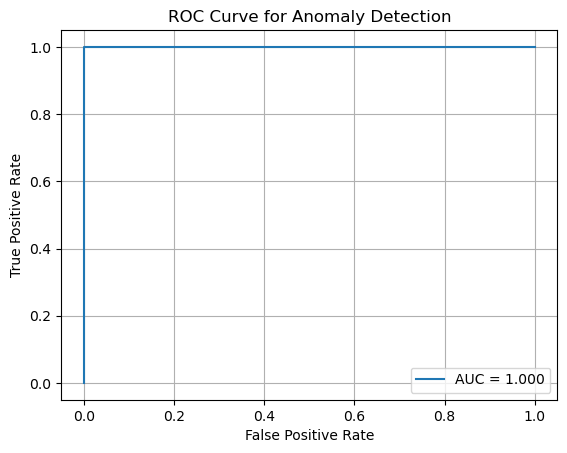

In [20]:
def reconstruction_error(model, sequence, scaler):
    model.eval()
    x = torch.tensor(scaler.transform(sequence[:-1]), dtype=torch.float32).unsqueeze(0)
    y_true = scaler.transform(sequence[1:])
    with torch.no_grad():
        y_pred = model(x).squeeze(0).numpy()
    return np.mean((y_pred - y_true)**2, axis=1)


labels = []
scores = []

for _, row in meta.iterrows():
    df = pd.read_csv(os.path.join(root_dir, row["filename"]))
    seq = df[["voltage", "current"]].values
    err = reconstruction_error(model, seq, dataset.scaler)
    labels.append(0 if row["label"] == "normal" else 1)
    scores.append(np.mean(err))


fpr, tpr, _ = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Anomaly Detection")
plt.legend()
plt.grid(True)
plt.savefig("images/roc_curve.png")
plt.show()


In [21]:
threshold = np.percentile([s for i, s in enumerate(scores) if labels[i] == 0], 95)

preds = [1 if s > threshold else 0 for s in scores]
acc = np.mean([int(p == l) for p, l in zip(preds, labels)])

print(f"Threshold: {threshold:.4f}")
print(f"Accuracy at threshold: {acc:.3f}")


Threshold: 0.2285
Accuracy at threshold: 0.990


In [22]:
os.makedirs("images", exist_ok=True)

def get_attention_maps(model, input_seq):
    model.eval()
    with torch.no_grad():
        embedded = model.input_proj(input_seq)
        pe = model.pos_encoder(embedded)
        maps = []
        for layer in model.transformer_encoder.layers:
            _, attn_weights = layer.self_attn(pe, pe, pe, need_weights=True)
            maps.append(attn_weights.squeeze(0).cpu().numpy())
        return maps

def save_attention_heatmaps(attn_maps, prefix="sample"):
    for i, layer_map in enumerate(attn_maps):
        for h in range(layer_map.shape[0]):
            plt.figure(figsize=(10, 6))
            sns.heatmap(layer_map[h], cmap="viridis")
            plt.title(f"Layer {i+1} - Head {h+1}")
            plt.savefig(f"images/{prefix}_L{i+1}_H{h+1}.png")
            plt.close()

def create_attention_gif(attn_maps, head=0, prefix="sample"):
    imgs = []
    for i, attn in enumerate(attn_maps):
        fig = plt.figure()
        sns.heatmap(attn[head], cmap="magma")
        plt.title(f"Layer {i+1} - Head {head+1}")
        fname = f"images/_frame_{i}.png"
        plt.savefig(fname)
        imgs.append(plt.imread(fname))
        plt.close()

    fig, ax = plt.subplots()
    im = ax.imshow(imgs[0])

    def update(i):
        im.set_array(imgs[i])
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=len(imgs), blit=True)
    ani.save(f"images/{prefix}_rollout_H{head+1}.gif", writer='pillow', fps=1)
    plt.close()

def compare_normal_vs_fault(model, normal_seq, fault_seq, scaler, prefix="compare"):
    fig, axes = plt.subplots(2, len(model.transformer_encoder.layers), figsize=(16, 6))
    model.eval()
    normal_input = torch.tensor(scaler.transform(normal_seq[:-1]), dtype=torch.float32).unsqueeze(0)
    fault_input = torch.tensor(scaler.transform(fault_seq[:-1]), dtype=torch.float32).unsqueeze(0)

    normal_maps = get_attention_maps(model, normal_input)
    fault_maps = get_attention_maps(model, fault_input)

    for i in range(len(normal_maps)):
        sns.heatmap(normal_maps[i][0], ax=axes[0, i], cbar=False)
        axes[0, i].set_title(f"Normal - Layer {i+1}")
        sns.heatmap(fault_maps[i][0], ax=axes[1, i], cbar=False)
        axes[1, i].set_title(f"Fault - Layer {i+1}")

    plt.tight_layout()
    plt.savefig(f"images/{prefix}_normal_vs_fault.png")
    plt.close()


In [23]:
normal_df = pd.read_csv(os.path.join(root_dir, meta[meta["label"] == "normal"].iloc[0]["filename"]))
fault_df = pd.read_csv(os.path.join(root_dir, meta[meta["label"] == "flicker"].iloc[0]["filename"]))
normal_seq = normal_df[["voltage", "current"]].values
fault_seq = fault_df[["voltage", "current"]].values

normal_input = torch.tensor(dataset.scaler.transform(normal_seq[:-1]), dtype=torch.float32).unsqueeze(0)
fault_input = torch.tensor(dataset.scaler.transform(fault_seq[:-1]), dtype=torch.float32).unsqueeze(0)

save_attention_heatmaps(get_attention_maps(model, normal_input), prefix="normal")
create_attention_gif(get_attention_maps(model, normal_input), head=0, prefix="normal")

save_attention_heatmaps(get_attention_maps(model, fault_input), prefix="flicker")
create_attention_gif(get_attention_maps(model, fault_input), head=0, prefix="flicker")

compare_normal_vs_fault(model, normal_seq, fault_seq, dataset.scaler, prefix="compare")
print("Completed adding pictures")

Completed adding pictures


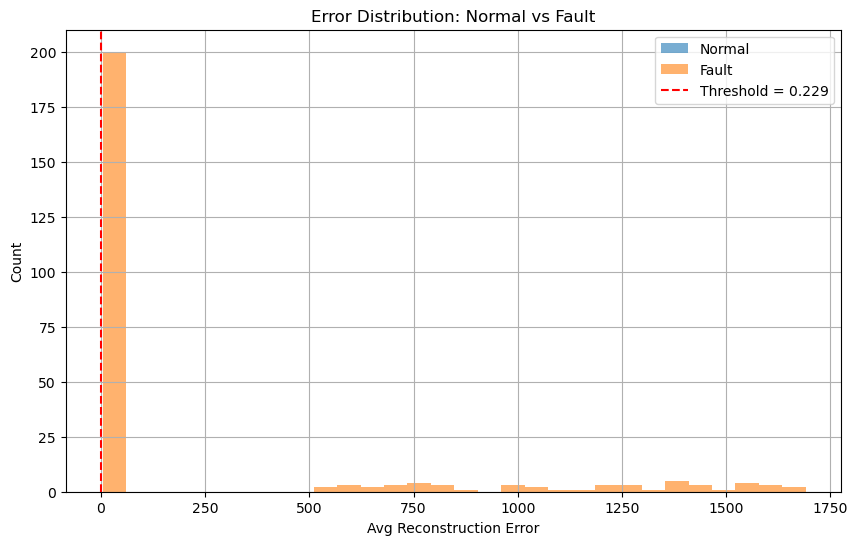

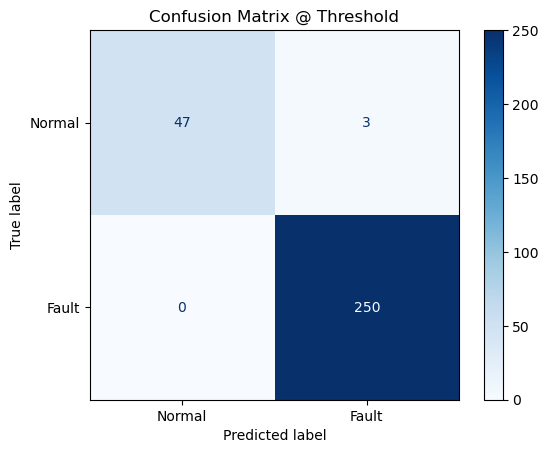

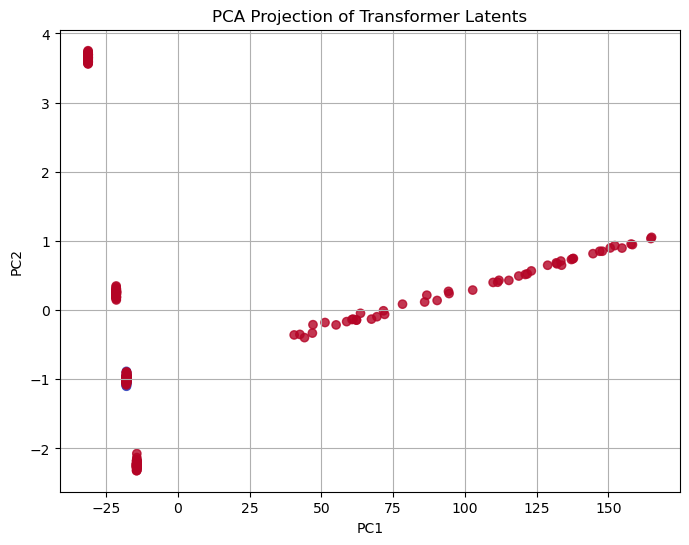

In [27]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import umap


normal_scores = [s for i, s in enumerate(scores) if labels[i] == 0]
fault_scores = [s for i, s in enumerate(scores) if labels[i] == 1]

plt.figure(figsize=(10,6))
plt.hist(normal_scores, bins=30, alpha=0.6, label="Normal")
plt.hist(fault_scores, bins=30, alpha=0.6, label="Fault")
plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold = {threshold:.3f}")
plt.xlabel("Avg Reconstruction Error")
plt.ylabel("Count")
plt.legend()
plt.title("Error Distribution: Normal vs Fault")
plt.grid(True)
plt.savefig("images/error_histogram.png")
plt.show()

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Fault"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix @ Threshold")
plt.savefig("images/confusion_matrix.png")
plt.show()


latent_reps = []
latent_labels = []

for _, row in meta.iterrows():
    df = pd.read_csv(os.path.join(root_dir, row["filename"]))
    seq = df[["voltage", "current"]].values
    input_seq = torch.tensor(dataset.scaler.transform(seq[:-1]), dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        embedded = model.input_proj(input_seq)
        pooled = embedded.mean(dim=1).squeeze().numpy()
        latent_reps.append(pooled)
        latent_labels.append(0 if row["label"] == "normal" else 1)

latent_reps = np.vstack(latent_reps)
label_names = np.array(latent_labels)


pca_proj = PCA(n_components=2).fit_transform(latent_reps)
plt.figure(figsize=(8,6))
plt.scatter(pca_proj[:,0], pca_proj[:,1], c=label_names, cmap='coolwarm', alpha=0.8)
plt.title("PCA Projection of Transformer Latents")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.savefig("images/pca_latent_projection.png")
plt.show()



In [ ]:
pip install umap